In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import csv
import random
import torch.nn as nn
import torch.optim as optim

class SequenceMaskedTicTacToeDataset(Dataset):
    def __init__(self, csv_file, sequence_length=25, state_dim=(3, 3)):
        self.data = []
        self.state_dim = state_dim
        self.sequence_length = sequence_length
        
        with open(csv_file, 'r') as file:
            csv_reader = csv.reader(file)
            next(csv_reader)  # Skip header
            current_sequence = []
            
            for row in csv_reader:
                agent = int(row[0])
                state = np.array([float(x) for x in row[1][1:-1].split()]).reshape(state_dim)
                current_sequence.append((agent, state))
                
                if len(current_sequence) == sequence_length:
                    self.data.append(current_sequence)
                    current_sequence = current_sequence[1:]  # Slide the window
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sequence = self.data[idx]
        
        # Choose a random position to mask
        mask_position = random.randint(0, self.sequence_length - 1)
        
        # Create masked version of the sequence
        masked_sequence = [state.copy() for _, state in sequence]
        original_sequence = [state for _, state in sequence]
        
        # Mask the chosen position
        mask = np.ones_like(masked_sequence[mask_position], dtype=bool)
        masked_sequence[mask_position] = np.full_like(masked_sequence[mask_position], -1)
        
        # Prepare the input tensor x
        x = np.array(masked_sequence)  # Shape: (sequence_length, state_dim)
        
        # Return only the next state (flattened) as target
        next_state_target = original_sequence[mask_position].flatten()  # Shape: (9,)
        agent_target = sequence[mask_position][0]  # Get the agent for the masked position
        
        # Ensure agent_target is 0-indexed
        agent_target = agent_target - 1 if agent_target > 0 else -1  # Assuming agents are originally 1 and 2
        
        return (
            torch.tensor(x, dtype=torch.float),  # This is now the input tensor x
            torch.tensor(next_state_target, dtype=torch.float),  # Original next state (flattened)
            torch.tensor(agent_target, dtype=torch.long),  # Agent for the masked position (0-indexed)
            torch.tensor(mask, dtype=torch.bool),
            torch.tensor(mask_position, dtype=torch.long)
        )


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMBranch(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMBranch, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return lstm_out


class GRUBranch(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(GRUBranch, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
    
    def forward(self, x):
        gru_out, _ = self.gru(x)
        return gru_out


class TransformerBranch(nn.Module):
    def __init__(self, input_dim, nhead, num_layers, hidden_dim):
        super(TransformerBranch, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, hidden_dim)  # Add a linear layer to map to hidden_dim

    def forward(self, x):
        # Rearrange input for transformer: (seq_len, batch_size, input_dim)
        x = x.permute(1, 0, 2)
        transformer_out = self.transformer(x)
        # Apply the linear layer to the output to ensure it matches hidden_dim
        transformer_out = self.fc(transformer_out)
        # Revert to original shape: (batch_size, seq_len, hidden_dim)
        transformer_out = transformer_out.permute(1, 0, 2)
        return transformer_out



class ConvNetBranch(nn.Module):
    def __init__(self, in_channels, num_filters):
        super(ConvNetBranch, self).__init__()
        self.conv = nn.Conv2d(in_channels, num_filters, kernel_size=1)
        self.fc = nn.Linear(num_filters * 3 * 3, num_filters)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, 1, 3, 3)
        batch_size, seq_len, channels, rows, cols = x.shape
        x = x.view(batch_size * seq_len, channels, rows, cols)  # Flatten for convolution
        x = torch.nn.functional.relu(self.conv(x))
        x = x.view(batch_size, seq_len, -1)  # Reshape back to (batch_size, sequence_length, num_filters * 3 * 3)
        x = self.fc(x)  # Apply fully connected layer
        return x


class SequenceTicTacToePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, nhead=3, dropout=0.2, conv_filters=16):
        super(SequenceTicTacToePredictor, self).__init__()
        
        self.lstm_branch = LSTMBranch(input_dim, hidden_dim, num_layers)
        self.gru_branch = GRUBranch(input_dim, hidden_dim, num_layers)
        self.transformer_branch = TransformerBranch(input_dim, nhead, num_layers, hidden_dim)  # Pass hidden_dim here
        self.convnet_branch = ConvNetBranch(1, conv_filters)

        combined_feature_dim = hidden_dim * 3 + conv_filters  # Adjusted to match the flattened conv output
        self.fc_state = nn.Linear(combined_feature_dim, 9)  # Output is flattened (3x3)
        self.fc_agent = nn.Linear(combined_feature_dim, 2)


    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Get outputs from each branch
        lstm_out = self.lstm_branch(x)[:, -1, :]  # Take only the last output
        gru_out = self.gru_branch(x)[:, -1, :]
        transformer_out = self.transformer_branch(x)[:, -1, :]

        # Debugging: Print shapes after each branch
        # print(f"LSTM output shape: {lstm_out.shape}")         # Expected: (batch_size, hidden_dim)
        # print(f"GRU output shape: {gru_out.shape}")           # Expected: (batch_size, hidden_dim)
        # print(f"Transformer output shape: {transformer_out.shape}")  # Expected: (batch_size, hidden_dim)

        x_conv = x.view(batch_size, seq_len, 1, 3, 3)  # Reshape for ConvNet
        conv_out = self.convnet_branch(x_conv)[:, -1, :]

        # Debugging: Print shape after ConvNet
        # print(f"ConvNet output shape: {conv_out.shape}")     # Expected: (batch_size, conv_filters)

        # Concatenate outputs from all branches
        concatenated = torch.cat([lstm_out, gru_out, transformer_out, conv_out], dim=-1)

        # Debugging: Print shape after concatenation
        # print(f"Concatenated output shape: {concatenated.shape}")  # Expected: (batch_size, combined_feature_dim)

        # Ensure the output shape matches what the fully connected layer expects
        next_state_pred = self.fc_state(concatenated).view(batch_size, 3, 3)
        agent_pred = self.fc_agent(concatenated)

        return next_state_pred, agent_pred






In [3]:
class SequenceMaskedTicTacToeDataset(Dataset):
    def __init__(self, csv_file, sequence_length=25, state_dim=(3, 3)):
        self.data = []
        self.state_dim = state_dim
        self.sequence_length = sequence_length
        
        with open(csv_file, 'r') as file:
            csv_reader = csv.reader(file)
            next(csv_reader)  # Skip header
            current_sequence = []
            
            for row in csv_reader:
                agent = int(row[0])
                state = np.array([float(x) for x in row[1][1:-1].split()]).reshape(state_dim)
                current_sequence.append((agent, state))
                
                if len(current_sequence) == sequence_length:
                    self.data.append(current_sequence)
                    current_sequence = current_sequence[1:]  # Slide the window
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sequence = self.data[idx]
        
        # Choose a random position to mask
        mask_position = random.randint(0, self.sequence_length - 1)
        
        # Create masked version of the sequence
        masked_sequence = [state.copy() for _, state in sequence]
        original_sequence = [state for _, state in sequence]
        
        # Mask the chosen position
        mask = np.ones_like(masked_sequence[mask_position], dtype=bool)
        masked_sequence[mask_position] = np.full_like(masked_sequence[mask_position], -1)
        
        # Prepare the input tensor x
        x = np.array(masked_sequence)  # Shape: (sequence_length, state_dim)
        
        # Return only the next state (flattened) as target
        next_state_target = original_sequence[mask_position].flatten()  # Shape: (9,)
        agent_target = sequence[mask_position][0]  # Get the agent for the masked position
        
        # Ensure agent_target is 0-indexed
        agent_target = agent_target - 1 if agent_target > 0 else -1  # Assuming agents are originally 1 and 2
        
        return (
            torch.tensor(x, dtype=torch.float),  # This is now the input tensor x
            torch.tensor(next_state_target, dtype=torch.float),  # Original next state (flattened)
            torch.tensor(agent_target, dtype=torch.long),  # Agent for the masked position (0-indexed)
            torch.tensor(mask, dtype=torch.bool),
            torch.tensor(mask_position, dtype=torch.long)
        )

In [4]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import pandas as pd

input_dim = 9  # 3x3 grid flattened
hidden_dim = 64
num_layers = 2
dropout = 0.2
nhead = 3  # Number of attention heads for transformer
num_epochs = 500
batch_size = 32  # Adjust as needed
sequence_length = 25
state_dim = (3, 3)

# Assuming `SequenceMaskedTicTacToeDataset` is defined elsewhere
dataset = SequenceMaskedTicTacToeDataset('../data/processed/synthetic/tic-tac-toe.csv', sequence_length=sequence_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create the model with updated parameters
model = SequenceTicTacToePredictor(input_dim, hidden_dim, num_layers, nhead, dropout, conv_filters=16)

# Define loss functions
next_state_criterion = nn.MSELoss()
agent_criterion = nn.CrossEntropyLoss(ignore_index=-1)

# Training loop
optimizer = optim.Adam(model.parameters(), lr=0.001)

results_df = pd.DataFrame(columns=['Epoch', 'Loss', 'MSE'])
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_next_state_preds = []
    all_next_state_targets = []
    
    for x, next_state_target, agent_target, mask, mask_position in dataloader:
        optimizer.zero_grad()
        
        x = x.float()  # Ensure input is float
        x = x.view(-1, sequence_length, input_dim)
        
        # Forward pass
        next_state_pred, agent_pred = model(x)
        
        # Reshape targets to match predictions
        next_state_target = next_state_target.view(-1, 3, 3)
        agent_target = agent_target.view(-1)
        
        # Compute losses
        next_state_loss = next_state_criterion(next_state_pred, next_state_target)
        agent_loss = agent_criterion(agent_pred, agent_target)
        
        loss = next_state_loss + agent_loss
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        all_next_state_preds.append(next_state_pred.detach().cpu().numpy())
        all_next_state_targets.append(next_state_target.detach().cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    
    all_next_state_preds = np.concatenate(all_next_state_preds, axis=0)
    all_next_state_targets = np.concatenate(all_next_state_targets, axis=0)
    mse = mean_squared_error(all_next_state_targets.reshape(-1, 9), all_next_state_preds.reshape(-1, 9))
    
    results_df = pd.concat([results_df, pd.DataFrame({'Epoch': [epoch + 1], 'Loss': [avg_loss], 'MSE': [mse]})], ignore_index=True)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, MSE: {mse:.4f}")

print("Training complete.")

c:\Users\vaibh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\vaibh\AppData\Local\Temp\ipykernel_2136\586914829.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'Epoch': [epoch + 1], 'Loss': [avg_loss], 'MSE': [mse]})], ignore_index=True)


Epoch [1/500], Loss: 1.6485, MSE: 1.0928
Epoch [2/500], Loss: 1.3665, MSE: 0.7253
Epoch [3/500], Loss: 1.2703, MSE: 0.6007
Epoch [4/500], Loss: 1.2240, MSE: 0.6437
Epoch [5/500], Loss: 1.2076, MSE: 0.6128
Epoch [6/500], Loss: 1.3421, MSE: 0.6138
Epoch [7/500], Loss: 1.4161, MSE: 0.6109
Epoch [8/500], Loss: 1.3588, MSE: 0.5963
Epoch [9/500], Loss: 1.4252, MSE: 0.6673
Epoch [10/500], Loss: 1.2784, MSE: 0.6323
Epoch [11/500], Loss: 1.3123, MSE: 0.6264
Epoch [12/500], Loss: 1.3213, MSE: 0.5814
Epoch [13/500], Loss: 1.2930, MSE: 0.5969
Epoch [14/500], Loss: 1.2613, MSE: 0.5945
Epoch [15/500], Loss: 1.3815, MSE: 0.6605
Epoch [16/500], Loss: 1.2706, MSE: 0.6093
Epoch [17/500], Loss: 1.2814, MSE: 0.6080
Epoch [18/500], Loss: 1.3011, MSE: 0.6042
Epoch [19/500], Loss: 1.2803, MSE: 0.6197
Epoch [20/500], Loss: 1.2731, MSE: 0.6079
Epoch [21/500], Loss: 1.3490, MSE: 0.6071
Epoch [22/500], Loss: 1.2508, MSE: 0.5752
Epoch [23/500], Loss: 1.2830, MSE: 0.6139
Epoch [24/500], Loss: 1.3198, MSE: 0.6204
E

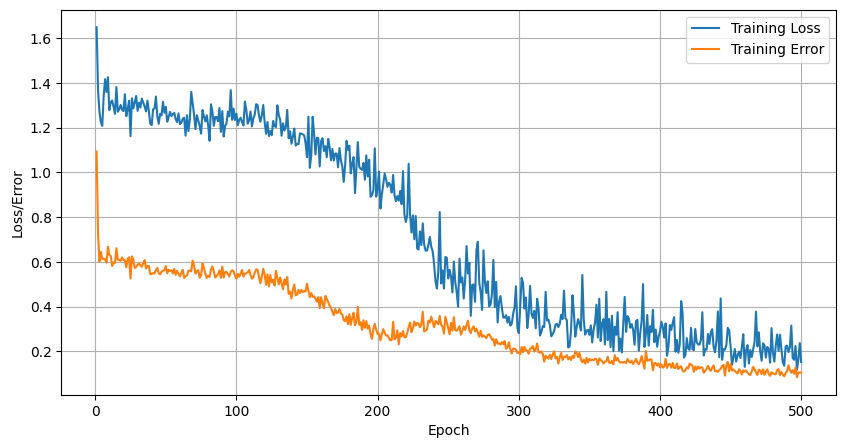

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(results_df['Epoch'], results_df['Loss'], label='Training Loss')
plt.plot(results_df['Epoch'], results_df['MSE'], label='Training Error')
plt.xlabel('Epoch')
plt.ylabel('Loss/Error')
plt.legend()
plt.grid(True)
plt.show()